In [1]:
import pandas as pd
import numpy as np

# Load generated predictions
all_preds = pd.read_csv('data/output/all_preds.csv')

# Convert to actual visitor counts
all_preds.iloc[:,[2,3,4,5,6,7,8]] = all_preds.iloc[:,[2,3,4,5,6,7, 8]].apply(np.expm1)

actual_visitors = pd.read_csv('data/air_visit_data.csv')

# Add actual visitor counts
all_preds = all_preds.merge(actual_visitors, how = 'left', on = ['air_store_id', 'visit_date'])
# Remove any rows that had NaN visitors, assume we know when a restaurant will be closed.
all_preds = all_preds[all_preds['visitors'].notna()]

# Remove rows with missing predictions for simplicity: 
all_preds = all_preds.dropna()

In [2]:
def ada_weighting(forecasts, actual, lr=0.2, p=5, prior_weights = None):
    """
    Args:
        forecasts: ndarray, axis 0: dim n > 0, axis 1: dim m > 1
        actual: ndarray, axis 0: dim n > 0, axis 1: dim m = 1
        lr: float
        p: int
        
    Returns: ndarray, n by m
    """
    weights = np.zeros((forecasts.shape[0], forecasts.shape[1]))
    errors = np.abs(forecasts - actual)**p
    
    # Initialize default weights for each forecast
    if prior_weights:
        curr_weights = prior_weights
    else:
        curr_weights = [1/fcsts.shape[1]] * fcsts.shape[1]
    # Iterative updates over every timestep
    for i in range(forecasts.shape[0]):
        # Normalize errors 
        curr_errors = (errors[i:i+1] + 0.00001) #/ np.sum(errors[i:i+1])  # 0.00001 is adjusting for possible 0 error

        alpha = lr * np.log(abs(1 - curr_errors)/curr_errors)

        #Weight update
        curr_weights = curr_weights * np.exp(alpha*curr_errors)
        curr_weights /= np.sum(curr_weights)
        
        weights[i] = curr_weights
        
    return weights
        

In [3]:
def proj_prob_simplex(v):
    u = -np.sort(-v)
    rho = 0
    for j in range(1, len(v)+1):
        if ((u[j-1] + (1 / j) * (1 - np.sum(u[0:j]))) > 0):
            rho = j
    lambd = (1/rho)*(1-np.sum(u[0:rho]))
    x = np.maximum(v + lambd, 0)
    return x


def online_grad_descent(forecasts, actual, lr=0.001, p=1, prior_weights = None):
    """
    Args:
        forecasts: ndarray, axis 0: dim n > 0, axis 1: dim m > 1
        actual: ndarray, axis 0: dim n > 0, axis 1: dim m = 1
        lr: float
        p: int
        
    Returns: ndarray, n by m
    """
    weights = np.zeros((forecasts.shape[0], forecasts.shape[1]))
    
    # Initialize default weights for each forecast
    if prior_weights:
        curr_weights = prior_weights
    else:
        curr_weights = [1/fcsts.shape[1]] * fcsts.shape[1]
    # Iterative (online) updates over every timestep
    for i in range(forecasts.shape[0]):
        gradient = p * ((forecasts[i:i+1] - actual[i]) * ((forecasts[i:i+1]*curr_weights) - (actual[i]*curr_weights))**(2*p-1))  / np.abs(((forecasts[i:i+1]*curr_weights) - actual[i])**p)
        
        # Update weights
        curr_weights -= lr * gradient
        
        # Project weights back to being positive and sum to 1
        curr_weights = proj_prob_simplex(curr_weights.flatten())
        curr_weights = curr_weights.reshape((1,7))

        weights[i] = curr_weights
        
    return weights



In [4]:
### Apply AdaWeights and Online Gradient Descent to the forecasts for each store individually.

prior_weights = [0.2, 0.05, 0.05, 0.05, 0.3, 0.3, 0.05]

all_weights_ogd = pd.DataFrame()
for store in all_preds.air_store_id.unique():
    curr_preds = all_preds[all_preds.air_store_id == store]
    
    fcsts = curr_preds.columns[2:-1]
    fcsts = curr_preds[fcsts].values
    actual = curr_preds.iloc[:, -1].values
    actual = actual.reshape((actual.shape[0], 1))
    
    res = pd.DataFrame(online_grad_descent(fcsts, actual, 0.001, 1, prior_weights = prior_weights))
    res['air_store_id'] = curr_preds.air_store_id.values
    res['visit_date'] = curr_preds.visit_date.values
    
    res.iloc[:, 0:7] = res.iloc[:, 0:7].shift(2)
    res[0:2].iloc[:, 0:7] = prior_weights
    
    all_weights_ogd = pd.concat([all_weights_ogd, res])

    
all_weights_ada = pd.DataFrame()
for store in all_preds.air_store_id.unique():
    curr_preds = all_preds[all_preds.air_store_id == store]
    fcsts = curr_preds.columns[2:-1]
    fcsts = curr_preds[fcsts].values
    actual = curr_preds.iloc[:, -1].values
    actual = actual.reshape((actual.shape[0], 1))
    
    res = pd.DataFrame(ada_weighting(fcsts, actual, 0.2, 5, prior_weights = prior_weights))
    res['air_store_id'] = curr_preds.air_store_id.values
    res['visit_date'] = curr_preds.visit_date.values
    
    res.iloc[:, 0:7] = res.iloc[:, 0:7].shift(2)
    res[0:2].iloc[:, 0:7] = prior_weights
    
    all_weights_ada = pd.concat([all_weights_ada, res])
    
    

e:\programming\blogs\adaptiveweighting\env\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
### Stacking
import random
import lightgbm as lgb
from sklearn import preprocessing

lgbm_learning_params = { #NOTE: Comments to the right are default parameter values for reference
    'verbose' : 0,
    'device_type' : 'cpu',
    'gpu_use_dp' : False,
    'force_row_wise' : True,
    'seed' : random.randrange(2147483646),
    
    'objective' : 'regression',
    'metric' : 'l2',
    'num_iterations' : 250,
    'boosting' : 'gbdt', #gbdt
    'learning_rate' : 0.1, #0.1
    'num_leaves' : 15, #31
    'tree_learner' : 'serial', #serial

    'max_depth' : -1, #-1
    'min_data_in_leaf' : 20, #20
    'min_sum_hessian_in_leaf' : 0.001, #0.001
    'bagging_fraction' : 0.8, #1
    'bagging_freq' : 1, #0
    'feature_fraction' : 1, #1
    'max_delta_step' : 0, #0
    'lambda_l1' : 0, #0
    'lambda_l2' : 0.1, #0
    'min_gain_to_split' : 0, #0

    'min_data_per_group': 100, #100
    'max_cat_threshold' : 32, #32
    'cat_l2' : 10, #10
    'cat_smooth' : 10, #10
    'max_cat_to_onehot' : 4, #4
    'top_k' : 20, #20

    #Dart Params
    'drop_rate' : 0.1, #0.1
    'max_drop' : 25, #50
    'skip_drop' : .5, #0.5
    'xgboost_dart_mode' : False, 
    'uniform_drop' : False, #False

    'max_bin' : 255, #255
}
le_store = preprocessing.LabelEncoder()
le_visit = preprocessing.LabelEncoder()
stack_data = all_preds.copy()
stack_data['air_store_id'] = le_store.fit_transform(stack_data['air_store_id'])
stack_data['visit_date_numeric'] = le_visit.fit_transform(stack_data['visit_date'])

stack_train = stack_data[stack_data.visit_date <= '2017-03-27']
stack_train_y = stack_train.visitors.values
stack_train = stack_train.drop(['visit_date', 'visitors'], axis = 1)

stack_test = stack_data[stack_data.visit_date >= '2017-03-29']
stack_test_y = stack_test.visitors.values
stack_test = stack_test.drop(['visit_date', 'visitors'], axis = 1)

lgbm_x_train = lgb.Dataset(data = stack_train, label = stack_train_y, categorical_feature = ['air_store_id', 'visit_date_numeric'])
lgbm = lgb.train(params = lgbm_learning_params, train_set = lgbm_x_train, categorical_feature = ['air_store_id', 'visit_date_numeric'], verbose_eval = 100)
preds = lgbm.predict(stack_test)


e:\programming\blogs\adaptiveweighting\env\lib\site-packages\lightgbm\engine.py:150: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [6]:
from sklearn import metrics
def RMSLE(y, pred):
    return metrics.mean_squared_error(np.log1p(y), np.log1p(pred))**0.5

# Printing the RMSLE for each individual forecast
fcsts = all_preds.columns[2:-1]
temp = all_preds[all_preds.visit_date >= '2017-03-29']
for fcst in fcsts:
    print(fcst, ' RMSLE', ':\t', RMSLE(temp['visitors'], temp[fcst]), sep = '')

# Computing the RMSLE for naively weighting each forecast
weights = [0.2, 0.05, 0.05, 0.05, 0.3, 0.3, 0.05]
combined = (temp[fcsts].values * weights).sum(axis = 1)
print('Combined', ' RMSLE', ':\t', RMSLE(temp['visitors'], combined), sep = '')

# Stacking RMSLE
print('Stacking_LGBM', ' RMSLE', ':\t', RMSLE(temp['visitors'], np.clip(preds, 0, None)), sep = '')

# Using computed AdaWeights and Gradient Descent results to calculate RMSLE for each
temp = all_preds[all_preds.visit_date >= '2017-03-29']
all_weights_ada = all_weights_ada[all_weights_ada.visit_date >= '2017-03-29']
all_weights_ogd = all_weights_ogd[all_weights_ogd.visit_date >= '2017-03-29']
ada = temp.iloc[:, 2:9].values * all_weights_ada.iloc[:, 0:7].values
ada = ada.sum(axis = 1)
print('AdaWeight', ' RMSLE', ':\t', RMSLE(temp['visitors'], ada), sep = '')
ogd = temp.iloc[:, 2:9].values * all_weights_ogd.iloc[:, 0:7].values
ogd = ogd.sum(axis = 1)
print('Gradient Descent', ' RMSLE', ':\t', RMSLE(temp['visitors'], ogd), sep = '')



GBM RMSLE:	0.5462405064945994
KNNR RMSLE:	0.5719314963816424
LGBM1 RMSLE:	0.6003849724999285
LGBM2 RMSLE:	0.5996173542566706
NN RMSLE:	0.49415153800138384
XGB1 RMSLE:	0.4988126403190667
XGB2 RMSLE:	0.5888418169447855
Combined RMSLE:	0.4875302567657409
Stacking_LGBM RMSLE:	0.5398642147986092
AdaWeight RMSLE:	0.4880147198130905
Gradient Descent RMSLE:	0.4882648417912996


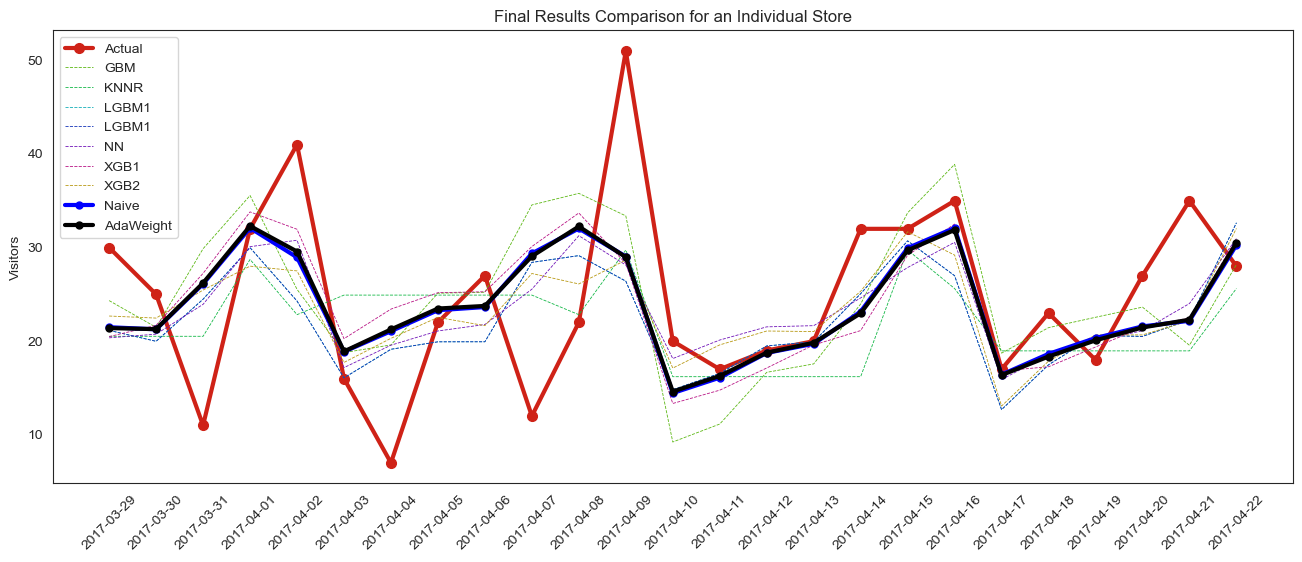

In [8]:
### Create final plot of results for one store. 

import matplotlib.pyplot as plt
import seaborn as sns

ada = temp.iloc[:, 2:9].values * all_weights_ada.iloc[:, 0:7].values
ada = ada.sum(axis = 1)
data = temp.copy()
data['Naive'] = combined
data['AdaWeight'] = ada
data = data[data.air_store_id == 'air_39dccf7df20b1c6a']
data = data.rename({'visitors' : 'Actual'}, axis = 1)

sns.set_style("white")
plt.rcParams["figure.figsize"] = (16,6)
plt.rcParams['figure.dpi'] = 100

plt.plot('visit_date', 'Actual', data=data, marker='o', markerfacecolor=sns.hls_palette(8, l=.45, s=.8)[0], markersize=7, color=sns.hls_palette(8, l=.45, s=.8)[0], linewidth=3)

plt.plot('visit_date', 'GBM', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[2], linewidth=.6, linestyle='dashed')
plt.plot('visit_date', 'KNNR', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[3], linewidth=.6, linestyle='dashed')
plt.plot('visit_date', 'LGBM1', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[4], linewidth=.6, linestyle='dashed')
plt.plot('visit_date', 'LGBM1', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[5], linewidth=.6, linestyle='dashed')
plt.plot('visit_date', 'NN', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[6], linewidth=.6, linestyle='dashed')
plt.plot('visit_date', 'XGB1', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[7], linewidth=.6, linestyle='dashed')
plt.plot('visit_date', 'XGB2', data=data, marker='', markerfacecolor='black', markersize=5, color=sns.hls_palette(8, l=.4, s=.8)[1], linewidth=.6, linestyle='dashed')

plt.plot('visit_date', 'Naive', data=data, marker='o', markerfacecolor='blue', markersize=5, color='blue', linewidth=3)
plt.plot('visit_date', 'AdaWeight', data=data, marker='o', markerfacecolor='black', markersize=5, color='black', linewidth=3)

plt.legend()
plt.ylabel('Visitors')
plt.xticks(rotation=45)
plt.title("Final Results Comparison for an Individual Store")
plt.savefig('data/figures/finalplot.png')